In [1]:
# Install library SMOTE
!pip install imbalanced-learn

# Import
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import layers, callbacks, regularizers
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load dataset
df = pd.read_csv('/content/KlasifikasiUTS.csv')
X = df.drop(columns=['Class'])
y = df['Class']

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9631 - loss: 0.3971 - precision: 0.9779 - recall: 0.9225 - val_accuracy: 0.9800 - val_loss: 0.0499 - val_precision: 1.0000 - val_recall: 0.9800
Epoch 2/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9904 - loss: 0.0346 - precision: 0.9909 - recall: 0.9835 - val_accuracy: 0.9941 - val_loss: 0.0213 - val_precision: 1.0000 - val_recall: 0.9941
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9937 - loss: 0.0242 - precision: 0.9933 - recall: 0.9900 - val_accuracy: 0.9966 - val_loss: 0.0176 - val_precision: 1.0000 - val_recall: 0.9966
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9950 - loss: 0.0197 - precision: 0.9941 - recall: 0.9927 - val_accuracy: 0.9985 - val_loss: 0.0123 - val_precision: 1.0000 - val_recall: 0.9985
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9959 - loss: 0.0172 - precision: 0.9948 - recall: 0.9942 - val_accuracy: 0.9977 - val_loss

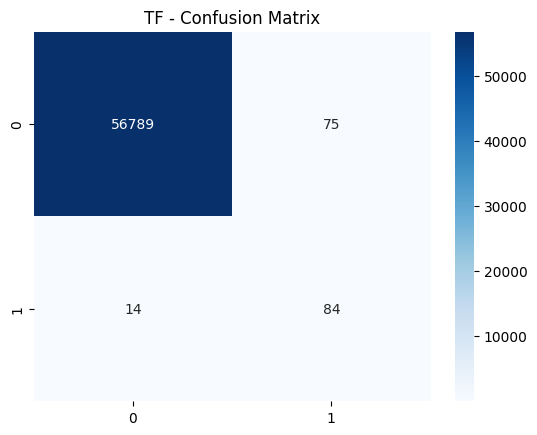

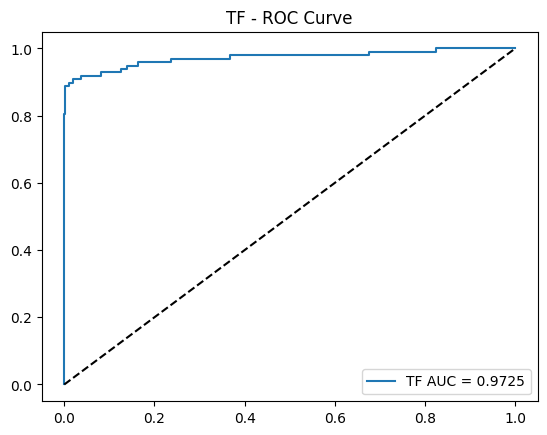


PyTorch Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.49      0.88      0.63        98

    accuracy                           1.00     56962
   macro avg       0.75      0.94      0.81     56962
weighted avg       1.00      1.00      1.00     56962



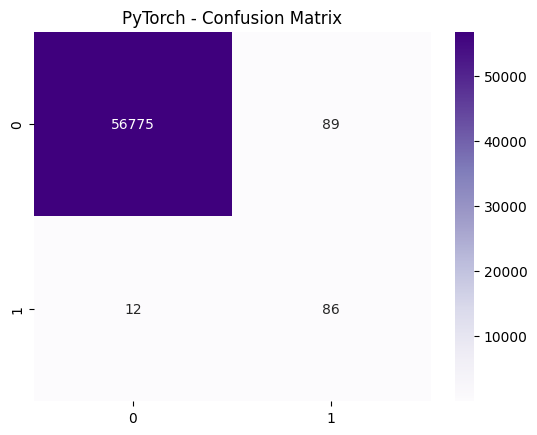

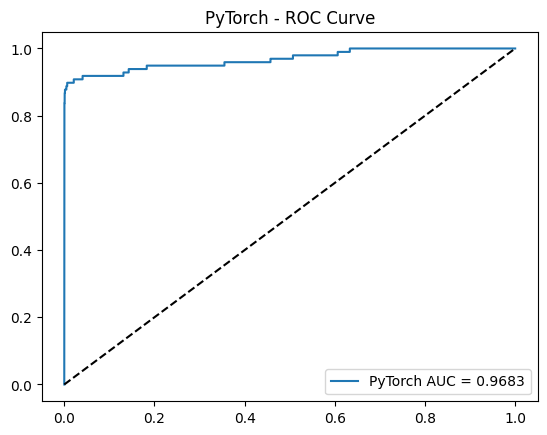

In [4]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Scaling
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# ✅ 2. MLP TENSORFLOW
import tensorflow as tf
from tensorflow.keras import layers, callbacks, regularizers
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

model_tf = tf.keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_res_scaled.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(1, activation='sigmoid')
])

model_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history_tf = model_tf.fit(X_train_res_scaled, y_train_res, validation_split=0.2,
                          epochs=50, batch_size=512, callbacks=[early_stop], verbose=1)

# EVALUASI TF
y_pred_prob_tf = model_tf.predict(X_test_scaled).flatten()
y_pred_tf = (y_pred_prob_tf > 0.5).astype(int)
print("\nTF Classification Report:")
print(classification_report(y_test, y_pred_tf))

cm_tf = confusion_matrix(y_test, y_pred_tf)
sns.heatmap(cm_tf, annot=True, fmt='d', cmap='Blues')
plt.title("TF - Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred_prob_tf)
plt.plot(fpr, tpr, label=f"TF AUC = {roc_auc_score(y_test, y_pred_prob_tf):.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("TF - ROC Curve")
plt.legend()
plt.show()

# ✅ 3. MLP PYTORCH
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

X_train_t = torch.tensor(X_train_res_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train_res.values, dtype=torch.float32).view(-1, 1)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=512, shuffle=True)

class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

model_pt = MLP(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_pt.parameters(), lr=0.001, weight_decay=1e-4)

for epoch in range(10):
    model_pt.train()
    for xb, yb in train_loader:
        pred = model_pt(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# EVALUASI PYTORCH
model_pt.eval()
with torch.no_grad():
    y_pred_prob_pt = model_pt(X_test_t).numpy().flatten()
    y_pred_pt = (y_pred_prob_pt > 0.5).astype(int)

print("\nPyTorch Classification Report:")
print(classification_report(y_test, y_pred_pt))

cm_pt = confusion_matrix(y_test, y_pred_pt)
sns.heatmap(cm_pt, annot=True, fmt='d', cmap='Purples')
plt.title("PyTorch - Confusion Matrix")
plt.show()

fpr_pt, tpr_pt, _ = roc_curve(y_test, y_pred_prob_pt)
plt.plot(fpr_pt, tpr_pt, label=f"PyTorch AUC = {roc_auc_score(y_test, y_pred_prob_pt):.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("PyTorch - ROC Curve")
plt.legend()
plt.show()


##===== KESIMPULAN & ANALISIS AKHIR =====

1. Dataset yang digunakan memiliki distribusi tidak seimbang (fraud ~0.17%).
   Oleh karena itu, dilakukan teknik oversampling menggunakan SMOTE hanya pada data training
   agar model dapat belajar dari data minoritas (fraud) secara adil.

2. Dua model Deep Learning dibangun dan diuji:
   - Model MLP dengan TensorFlow (Keras)
   - Model MLP dengan PyTorch

3. Teknik deep learning yang digunakan:
   - Dropout untuk regularisasi
   - Batch Normalization
   - Optimizer Adam
   - L2 weight decay (regularisasi)
   - Early stopping
   - Arsitektur 128 → 64 → 1 neuron dengan aktivasi sigmoid

4. Evaluasi dilakukan menggunakan metrik:
   - Accuracy
   - Precision
   - Recall
   - F1-score
   - Confusion Matrix
   - AUC-ROC

##=========== PERFORMA MODEL ===========

TensorFlow:
- Precision (fraud): 0.53
- Recall (fraud):    0.86
- F1-score:          0.65
- AUC:               0.9725
- False Positives:   75
- False Negatives:   14

PyTorch:
- Precision (fraud): 0.49
- Recall (fraud):    0.88
- F1-score:          0.63
- AUC:               0.9683
- False Positives:   89
- False Negatives:   12

##=========== KESIMPULAN MODEL TERBAIK ===========

Model TensorFlow dinilai sebagai model terbaik karena:
✔ Memiliki AUC tertinggi (0.9725)
✔ Precision lebih baik daripada PyTorch (false alarm lebih sedikit)
✔ F1-score sedikit lebih tinggi
✔ Performa secara keseluruhan lebih stabil dan cocok untuk deteksi fraud nyata

Model PyTorch juga memberikan performa sangat baik, terutama dari sisi recall,
namun menghasilkan lebih banyak false positive yang berpotensi mengganggu sistem produksi.

==================================================
